In [1]:
import numpy as np

from pycircstat2 import Circular, load_data, circ_plot
from pycircstat2.descriptive import circ_mean
from pycircstat2.utils import angrange

## Circular median: how to define it

### Groupped data

Circular Data

Summary
-------
  Grouped?: Yes
  Unit: degree
  Sample size: 714
  Angular mean: 314.27 ( p=0.0000 *** ) 
  Angular mean CI (0.95): 311.01 - 317.53
  Angular median: 313.78 
  Angular deviation (s): 42.91 
  Circular standard deviation (s0): 46.48 
  Concentration (r): 0.72
  Concentration (kappa): 2.11

Signif. codes:
--------------
 0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Method
------
  Angular median: deviation
  Angular mean CI: dispersion

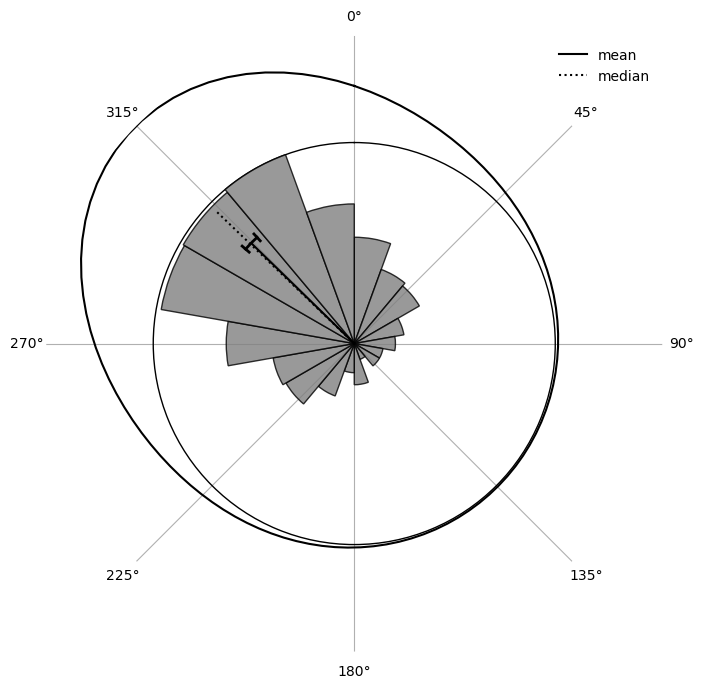

In [2]:
d_mallard = load_data('mallard', source='mardia')
c_mallard = Circular(data=d_mallard['θ'].values, w=d_mallard['w'].values)
circ_plot(c_mallard)
c_mallard

The circular median of groupped data is defined as the angle divided the area of bars into two equal halves.

### Ungrouped data

Circular Data

Summary
-------
  Grouped?: No
  Unit: degree
  Sample size: 24
  Angular mean: 11.80 ( p=0.0003 *** ) 
  Angular mean CI (0.95): 348.37 - 27.05
  Angular median: 20.00 
  Angular median CI (0.95): 350.00 - 35.00
  Angular deviation (s): 53.56 
  Circular standard deviation (s0): 61.41 
  Concentration (r): 0.56
  Concentration (kappa): 1.37

Signif. codes:
--------------
 0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Method
------
  Angular median: count
  Angular mean CI: bootstrap

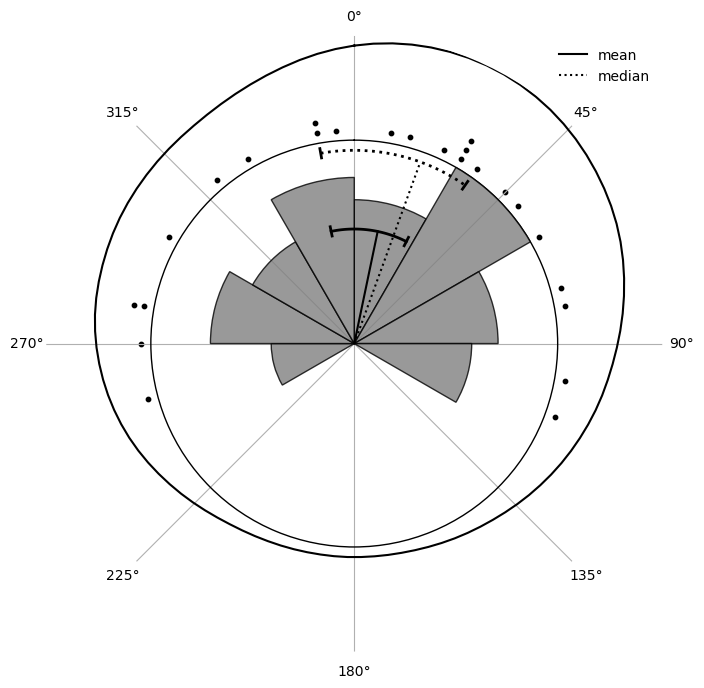

In [3]:
d_zar_ex4_ch27 = load_data('D8', source='zar')
c_zar_ex4_ch27 = Circular(data=d_zar_ex4_ch27['θ'].values, kwargs_median={'method': 'count'}, kwargs_mean_ci={'method': 'bootstrap'})
c_zar_ex4_ch27.plot()
c_zar_ex4_ch27

#### Method 1: counting number of data point in half circle.

This approach is intuitive and fit with the definition of circularmedian: any angle that can divide the data set into two equal half can be considered as the median.

But in practice this is problematic, as float comparison in most programming language is problemtic. 

In [4]:
from pycircstat2.utils import angrange
from pycircstat2.descriptive import circ_mean
def circ_median_count(alpha):

    n = len(alpha)
    alpha_rotated = angrange((alpha[:, None] - alpha)).round(5)

    # count number of points on the right (0, 180), excluding the boundaries
    right = np.logical_and(alpha_rotated > 0., alpha_rotated < np.round(np.pi, 5)).sum(0)
    # count number of points on the boundaries
    exact = np.logical_or(np.isclose(alpha_rotated, 0.), np.isclose(alpha_rotated, np.round(np.pi, 5))).sum(0)
    # count number of points on the left (180, 360), excluding the boundaries
    left = n - right - 0.5 * exact
    # find the point(s) location where the difference of number of points 
    # on right and left is/ are minimal
    diff = np.abs(right - left)
    idx_candidates = np.where(diff == diff.min())[0]

    # if number of potential median is the same as the number of data point
    # meaning that the data is more or less uniformly distributed. Retrun Nan.
    if len(idx_candidates) == len(alpha):
        median = np.nan
    # if number of potential median is 1, return it as median
    elif len(idx_candidates) == 1:
        median = alpha[idx_candidates][0]
    # if there are more than one potential median, 
    # do we need to distinguish odd or even? 
    else:
        median = circ_mean(alpha[idx_candidates])[0]

    return median

#### Method 2: circular mean deviation (Mardia's median)

Any angle ($\hat\theta$) that has the smallest circular mean deviation (d) can be considered as the median of a certain data set.

$$d = \pi - \frac{1}{n}\sum_{i}^{n} |\pi - |\theta_i - \hat\theta||$$

The pro of this approach is that it is easy to compute, and does not have to distinguish the oddness of the sample size. The con is that it might yield multiple results.

In [5]:
from pycircstat2.descriptive import circ_mean
def circ_mean_deviation(alpha, beta):
    return np.pi - np.mean(np.abs(np.pi - np.abs(alpha - beta[:, None])), 1)

def circ_median(alpha):

    angdist = circ_mean_deviation(alpha, alpha)
    idx_candidates = np.where(angdist == angdist.min())[0]

    # print(idx_candidates)

    if len(idx_candidates) == len(alpha):
        median = np.nan
    elif len(idx_candidates) == 1:
        median = alpha[idx_candidates][0]
    else:
        median = circ_mean(alpha[idx_candidates])[0]

    return median

### Edge cases

#### Uniformly distributed

Circular median is undefined if all data points are uniformly distributed

Circular Data

Summary
-------
  Grouped?: No
  Unit: degree
  Sample size: 4
  Angular mean: nan ( p=1.0000  ) 
  Angular median: nan 
  Angular deviation (s): 81.03 
  Circular standard deviation (s0): 494.00 
  Concentration (r): 0.00
  Concentration (kappa): 0.00

Signif. codes:
--------------
 0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Method
------
  Angular median: deviation
  Angular mean CI: None

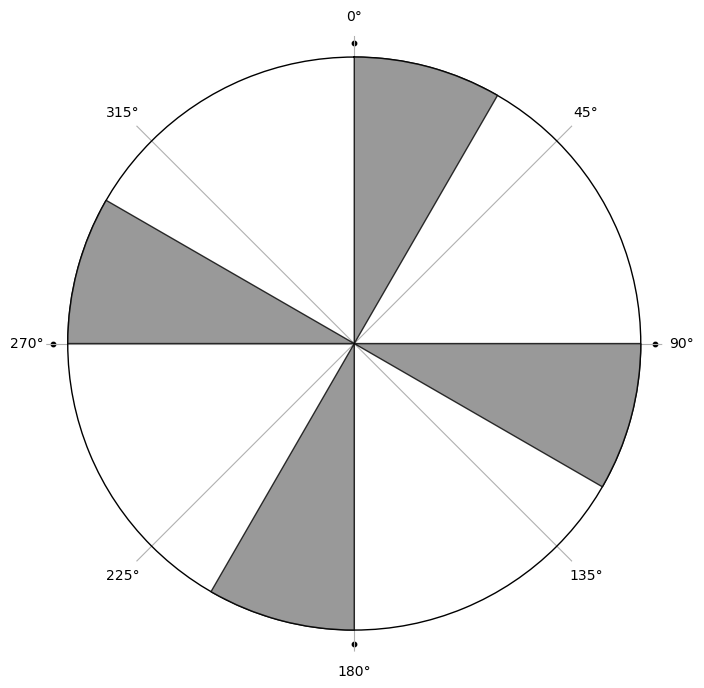

In [6]:
d_uniform_ungrouped = np.array([0., 90., 180., 270.])
c_uniform_ungrouped = Circular(data=d_uniform_ungrouped, n_clusters=1)
c_uniform_ungrouped.plot(plot_density=False)
c_uniform_ungrouped

The same applied to grouped data.

Circular Data

Summary
-------
  Grouped?: Yes
  Unit: degree
  Sample size: 4
  Angular mean: nan ( p=1.0000  ) 
  Angular median: nan 
  Angular deviation (s): 81.03 
  Circular standard deviation (s0): 494.82 
  Concentration (r): 0.00
  Concentration (kappa): 0.00

Signif. codes:
--------------
 0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Method
------
  Angular median: deviation
  Angular mean CI: None

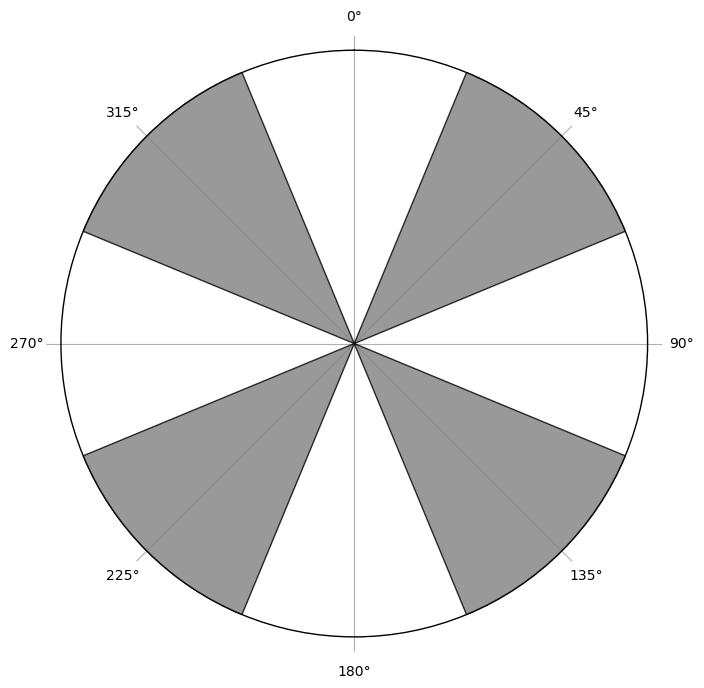

In [7]:
d_uniform_grouped = np.arange(0, 360, 45)
w_uniform_grouped = np.tile([0, 1], 4)

c_uniform_grouped = Circular(data=d_uniform_grouped, w=w_uniform_grouped, n_clusters=1)
c_uniform_grouped.plot(plot_density=False)
c_uniform_grouped

#### Multiple ties

There's a concern about how to deal with tied points. But it's not an issue if we use minimal circular mean deviation as the median.

Circular Data

Summary
-------
  Grouped?: No
  Unit: degree
  Sample size: 6
  Angular mean: 90.00 ( p=0.2738  ) 
  Angular median: 90.00 
  Angular median CI (0.97): 0.00 - 180.00
  Angular deviation (s): 58.91 
  Circular standard deviation (s0): 70.27 
  Concentration (r): 0.47
  Concentration (kappa): 0.75

Signif. codes:
--------------
 0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Method
------
  Angular median: deviation
  Angular mean CI: None

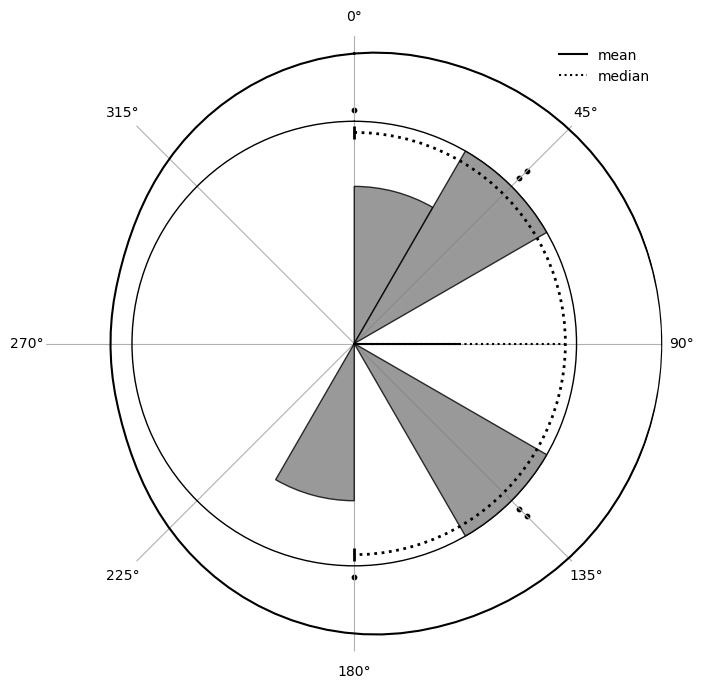

In [8]:
d_ties_ungrouped = np.array([0, 45, 45, 135,135, 180])
c_ties_ungrouped = Circular(data=d_ties_ungrouped)
c_ties_ungrouped.plot()
c_ties_ungrouped

Circular Data

Summary
-------
  Grouped?: No
  Unit: degree
  Sample size: 7
  Angular mean: 78.69 ( p=0.1577  ) 
  Angular median: 45.00 
  Angular median CI (0.88): 45.00 - 135.00
  Angular deviation (s): 56.43 
  Circular standard deviation (s0): 66.00 
  Concentration (r): 0.52
  Concentration (kappa): 0.96

Signif. codes:
--------------
 0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Method
------
  Angular median: deviation
  Angular mean CI: None

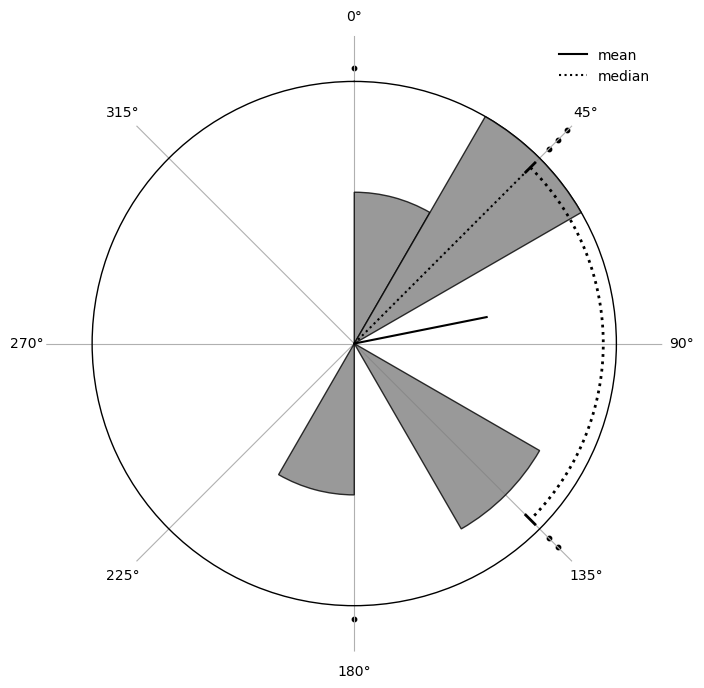

In [9]:
d_unties_ungrouped = np.array([0, 45, 45, 45, 135,135, 180])
c_unties_ungrouped = Circular(data=d_unties_ungrouped)
c_unties_ungrouped.plot(plot_density=False)
c_unties_ungrouped

It's a little bit trickier for grouped data, especially when there are empty bins in between. In those cases, we find the outer bounds of the tied bins, then compute the circular mean of them as the median.

Circular Data

Summary
-------
  Grouped?: Yes
  Unit: degree
  Sample size: 6
  Angular mean: 337.50 ( p=0.1505  ) 
  Angular median: 337.50 
  Angular deviation (s): 52.65 
  Circular standard deviation (s0): 60.01 
  Concentration (r): 0.56
  Concentration (kappa): 1.12

Signif. codes:
--------------
 0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Method
------
  Angular median: deviation
  Angular mean CI: None

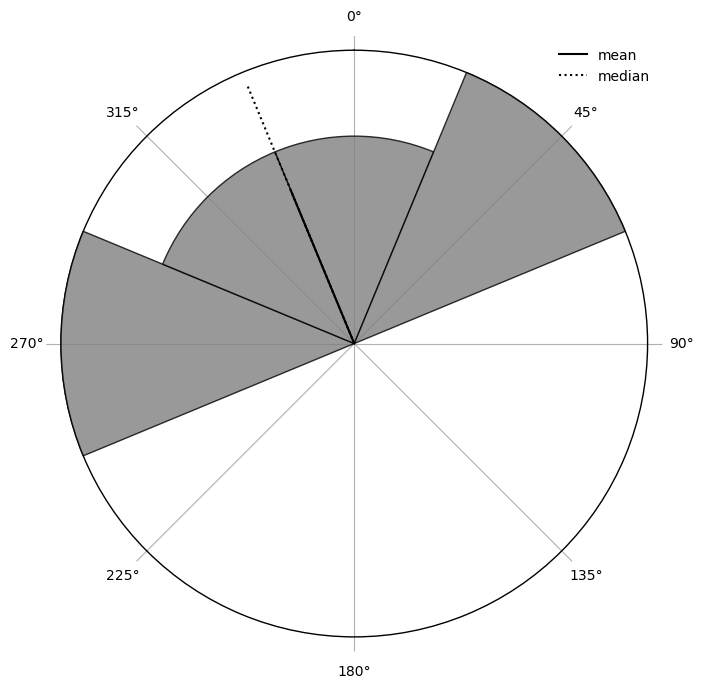

In [10]:
from arviz import plot_density


d_ties_grouped = np.arange(0, 360, 45)
w_ties_grouped = np.array([1, 2, 0, 0, 0, 0, 2, 1])
c_ties_grouped = Circular(data=d_ties_grouped, w=w_ties_grouped)
c_ties_grouped.plot(plot_density=False)
c_ties_grouped

Circular Data

Summary
-------
  Grouped?: Yes
  Unit: degree
  Sample size: 6
  Angular mean: 90.00 ( p=0.2738  ) 
  Angular median: 90.00 
  Angular deviation (s): 58.22 
  Circular standard deviation (s0): 69.05 
  Concentration (r): 0.47
  Concentration (kappa): 0.75

Signif. codes:
--------------
 0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Method
------
  Angular median: deviation
  Angular mean CI: None

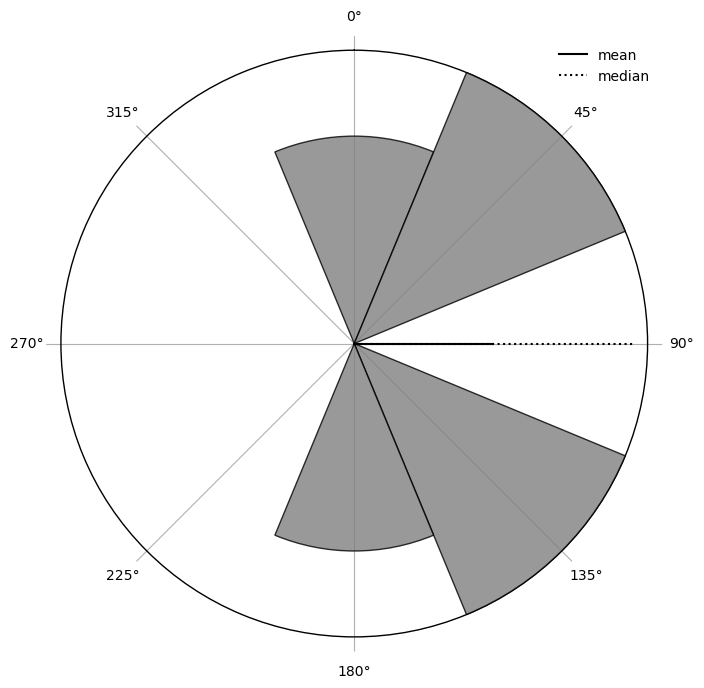

In [11]:
d_ties_grouped = np.arange(0, 360, 45)
w_ties_grouped = np.array([1, 2, 0, 2, 1, 0, 0, 0])
c_ties_grouped = Circular(data=d_ties_grouped, w=w_ties_grouped)
c_ties_grouped.plot(plot_density=False)
c_ties_grouped

Circular Data

Summary
-------
  Grouped?: Yes
  Unit: degree
  Sample size: 6
  Angular mean: 112.50 ( p=0.9135  ) 
  Angular median: 112.50 
  Angular deviation (s): 75.54 
  Circular standard deviation (s0): 115.54 
  Concentration (r): 0.13
  Concentration (kappa): 0.00

Signif. codes:
--------------
 0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Method
------
  Angular median: deviation
  Angular mean CI: None

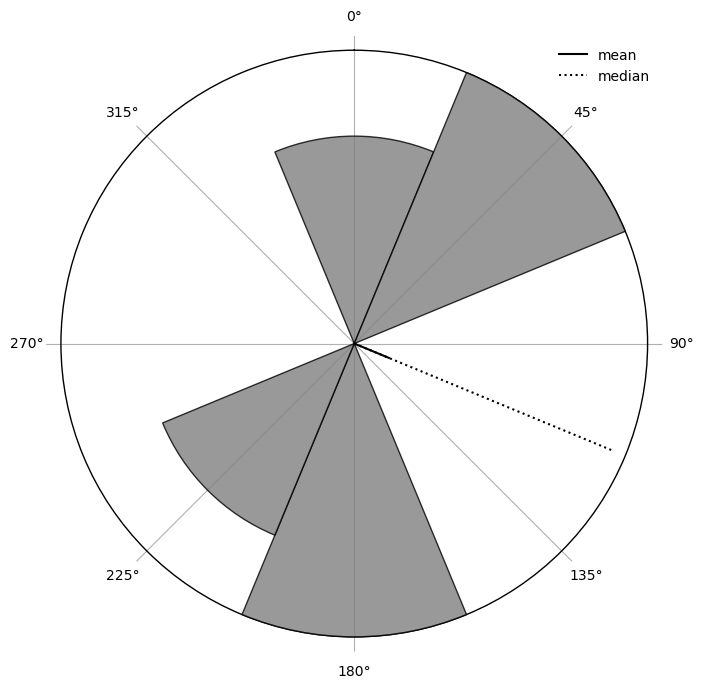

In [12]:
d_ties_grouped = np.arange(0, 360, 45)
w_ties_grouped = np.array([1, 2, 0, 0, 2, 1, 0, 0])
c_ties_grouped = Circular(data=d_ties_grouped, w=w_ties_grouped)
c_ties_grouped.plot(plot_density=False)
c_ties_grouped

## More examples

In [13]:
d_ex3 = load_data('B6','fisher')

In [14]:
c_ex3_s0 = Circular(np.sort(d_ex3[d_ex3.set==2]['θ'].values[:10]))
c_ex3_s1 = Circular(np.sort(d_ex3[d_ex3.set==2]['θ'].values[:20]), kwargs_median={'method': 'deviation'})
c_ex3_s2 = Circular(np.sort(d_ex3[d_ex3.set==2]['θ'].values))

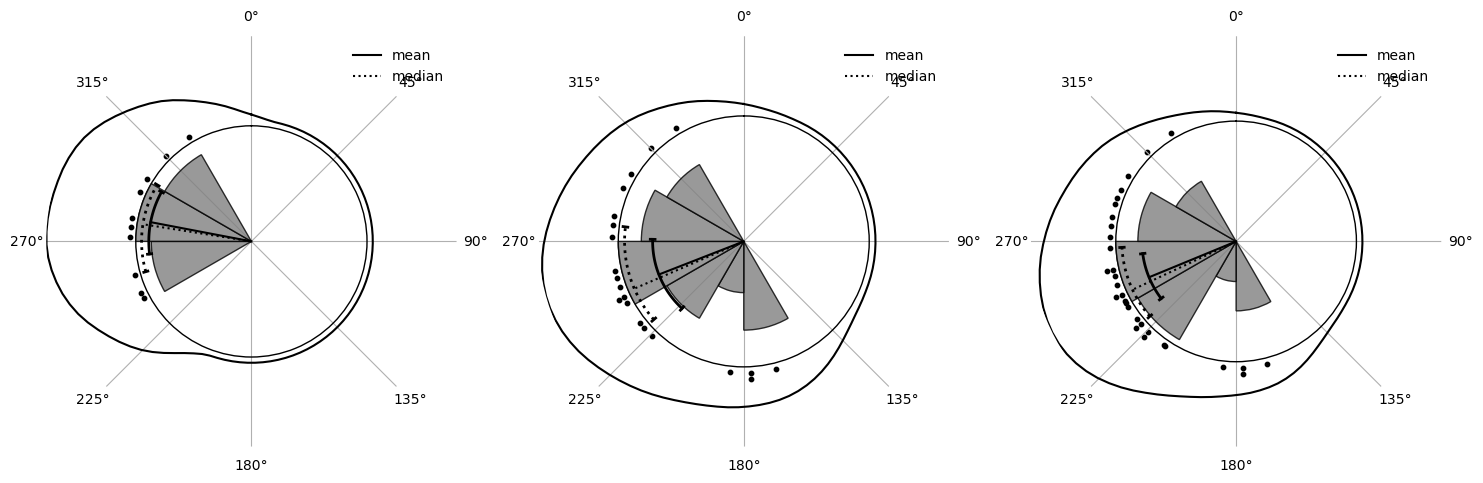

In [15]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 3, figsize=(18, 6),subplot_kw=dict(projection='polar'))
c_ex3_s0.plot(ax[0])
c_ex3_s1.plot(ax[1])
c_ex3_s2.plot(ax[2])

In [16]:
%load_ext watermark
%watermark --time --date --timezone --updated --python --iversions --watermark -p pycircstat2

Last updated: 2023-01-20 15:20:02CET

Python implementation: CPython
Python version       : 3.10.6
IPython version      : 8.5.0

pycircstat2: 0.1.0

matplotlib: 3.5.3
sys       : 3.10.6 | packaged by conda-forge | (main, Aug 22 2022, 20:43:44) [Clang 13.0.1 ]
numpy     : 1.23.5

Watermark: 2.3.1

